In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import qcodes as qc
import os
from qcodes import (Measurement,
                    experiments,
                    initialise_database,
                    initialise_or_create_database_at,
                    load_by_guid,
                    load_by_run_spec,
                    load_experiment,
                    load_last_experiment,
                    load_or_create_experiment,
                    new_experiment,
                    ManualParameter)
import matplotlib.pyplot as plt

# db_name = "../data/GeSiNW_Qubit_VTI01_Jonas_4.db" # Database name
db_name = "../data/GeSiNW_fully_autonomous_tuning.db" # Database name
sample_name = "Butch" # Sample name
exp_name = "Qubit_Search" # Experiment name

db_file_path = os.path.join(os.getcwd(), db_name)
qc.config.core.db_location = db_file_path
initialise_or_create_database_at(db_file_path)

experiment = load_or_create_experiment(experiment_name = exp_name,
                                       sample_name = sample_name)

plt.style.use('default')
import sys
sys.path.append('../')

# Load data

In [2]:
# local_ids = [293, 294]
# from qcodes.dataset import (
#     Measurement,
#     connect,
#     extract_runs_into_db,
#     load_experiment_by_name,
#     load_or_create_experiment,
# )
# source_conn = connect(db_name)
# target_path = "../data/GeSiNW_fully_autonomous_tuning.db"
# target_conn = connect(target_path)
# for _id in local_ids:
#     extract_runs_into_db(db_name, target_path, _id)

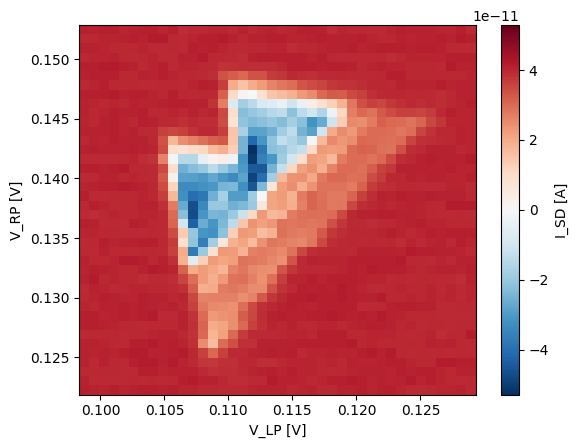

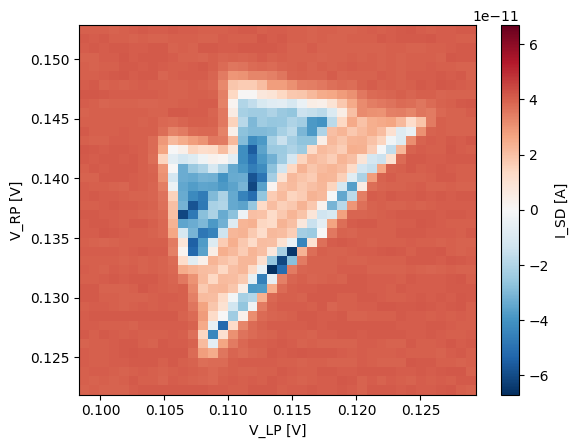

In [6]:
ds_low_magnet = load_by_guid('063410be-0000-0000-0000-018c04e0abda')
ds_low_magnet.to_xarray_dataset()["I_SD"].plot()
plt.show()
ds_high_magnet = load_by_guid('34b00bbd-0000-0000-0000-018c04e74c96')
ds_high_magnet.to_xarray_dataset()["I_SD"].plot()

In [9]:
data_high_magnet_xarray = ds_high_magnet.to_xarray_dataset()
data_low_magnet_xarray = ds_low_magnet.to_xarray_dataset()

# Apply Method

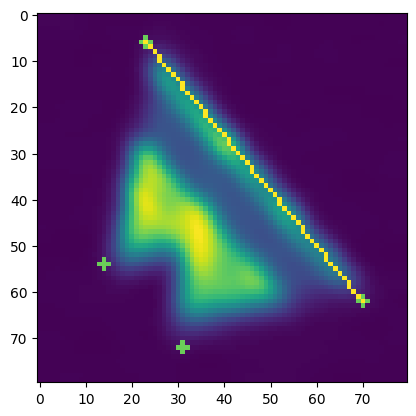

PSB detected: True


In [16]:
from signal_processing.bias_triangle_processing.bias_triangle_detection.alt_PSB_detection import PSB_detector_new
from signal_processing.bias_triangle_processing.bias_triangle_detection.btriangle_properties import \
    detect_base_alt_slope
from pipelines.utils import draw_boxes_and_preds
from signal_processing import EnsembleClassifier
from signal_processing.bias_triangle_processing.bias_triangle_detection import btriangle_detection, btriangle_properties
from signal_processing.bias_triangle_processing.bias_triangle_detection import btriangle_location_detection

invert_current = True
bias_direction = 'positive_bias'
if invert_current:
    data_high_magnet_analysis = -data_high_magnet_xarray["I_SD"].to_numpy()
    data_low_magnet_analysis = -data_low_magnet_xarray['I_SD'].to_numpy()
else:
    data_high_magnet_analysis = data_high_magnet_xarray['I_SD'].to_numpy()
    data_low_magnet_analysis = data_low_magnet_xarray['I_SD'].to_numpy()


axes_values = []
axes_values_names = []
axes_units = []

for item, n in dict(data_high_magnet_xarray.dims).items():
    axes_values.append(data_high_magnet_xarray[item].to_numpy())
    axes_values_names.append(data_high_magnet_xarray[item].long_name)
    axes_units.append(data_high_magnet_xarray[item].unit)

def psb_via_segmentation(blocked, unblocked, bias_direction="positive_bias"):
    res_h = 2
    relative_min_area = 0.01
    allow_MET = False
    thr_method = 'triangle'
    denoising = True
    triangle_direction = "down"

    if bias_direction == "positive_bias":
        pass
    elif bias_direction == "negative_bias":
        unblocked = unblocked.T
        blocked = blocked.T
    else:
        raise NotImplementedError

    min_area_h = (unblocked.shape[0] * unblocked.shape[1] * res_h * res_h) * relative_min_area

    unblocked, ims, masks = btriangle_detection.triangle_segmentation_alg(unblocked,
                                                                          res=res_h,
                                                                          min_area=min_area_h,
                                                                          thr_method=thr_method,
                                                                          denoising=denoising,
                                                                          allow_MET=allow_MET,
                                                                          direction=triangle_direction)
    try:
        base, corner_pts, c_im = detect_base_alt_slope(unblocked, masks, 'down')
    except:
        print(f'Error caught, base detection failed')
        return False
    plt.imshow(c_im)
    plt.show()
    min_area_h = (blocked.shape[0] * blocked.shape[1] * res_h * res_h) * relative_min_area

    blocked, ims2, masks2 = btriangle_detection.triangle_segmentation_alg(blocked,
                                                                          res=res_h,
                                                                          min_area=min_area_h,
                                                                          thr_method=thr_method,
                                                                          denoising=denoising,
                                                                          allow_MET=allow_MET,
                                                                          direction=triangle_direction)
    slope_tol = 0.4
    int_tol = 0.05
    seg_tol = 0.05
    median = False
    pair, PSB = PSB_detector_new(unblocked,
                                 blocked,
                                 base,
                                 masks,
                                 triangle_direction,
                                 slope_tol=slope_tol,
                                 int_tol=int_tol,
                                 median=median,
                                 seg_tol=seg_tol)
    return PSB

prediction = psb_via_segmentation(data_low_magnet_analysis, data_high_magnet_analysis)
print(f'PSB detected: {prediction}')